In [3]:
import pandas as pd
import parser
import reverser
from sampler_lib import *
from contextlib import redirect_stdout, redirect_stderr

In [4]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set display width
pd.set_option("display.max_colwidth", None)  # Set max column width

particle_df = pd.read_pickle('Dataframes/particles_df_errors_f0.pkl')
print(particle_df.tail(n=10))
print("\n")

decay_df = pd.read_pickle('Dataframes/decays_df_errors_f0.pkl')
print(decay_df.tail(n=10))
print("\n")

id = 9000221
print(particle_df[particle_df["ID"] == id])

          ID      Name  Mass (GeV)  Width (GeV)  Degeneracy  Baryon no.  Strangeness no.  Charm no.  Bottom no.  Isospin  Charge  No. of decay channels  Mass Error Pos (GeV)  Mass Error Neg (GeV)  Width Error Pos (GeV)  Width Error Neg (GeV)
730      221       eta       0.547      0.00118           1           0                0          0           0      0.0       0                      3          1.733421e-05          1.733421e-05           4.520066e-08           4.520066e-08
731  9000221   f0(500)       0.600      0.45000           1           0                0          0           0      0.0       0                      2          2.000000e-01          2.000000e-01           3.500000e-01           3.500000e-01
732      311        K0       0.498      0.00000           1           0                1          0           0      0.5       0                      1          1.299020e-05          1.299020e-05           0.000000e+00           0.000000e+00
733     -311   Anti-K0       0.4

### Possibly Changing f0 params

In [5]:
f0_mass = 0.449
f0_mass_err_plus = 0.022
f0_mass_err_minus = 0.016

f0_width = 0.550
f0_width_err_plus = 0.025
f0_width_err_minus = 0.025

# Update particle properties in the dataframes
particle_df.loc[particle_df["ID"] == id, "Mass (GeV)"] = f0_mass
particle_df.loc[particle_df["ID"] == id, "Mass Error Pos (GeV)"] = f0_mass_err_plus
particle_df.loc[particle_df["ID"] == id, "Mass Error Neg (GeV)"] = f0_mass_err_minus
particle_df.loc[particle_df["ID"] == id, "Width (GeV)"] = f0_width
particle_df.loc[particle_df["ID"] == id, "Width Error Pos (GeV)"] = f0_width_err_plus
particle_df.loc[particle_df["ID"] == id, "Width Error Neg (GeV)"] = f0_width_err_minus

print(particle_df.tail(n=10))
print("\n")

print(decay_df.tail(n=10))
print("\n")

          ID      Name  Mass (GeV)  Width (GeV)  Degeneracy  Baryon no.  Strangeness no.  Charm no.  Bottom no.  Isospin  Charge  No. of decay channels  Mass Error Pos (GeV)  Mass Error Neg (GeV)  Width Error Pos (GeV)  Width Error Neg (GeV)
730      221       eta       0.547      0.00118           1           0                0          0           0      0.0       0                      3          1.733421e-05          1.733421e-05           4.520066e-08           4.520066e-08
731  9000221   f0(500)       0.449      0.55000           1           0                0          0           0      0.0       0                      2          2.200000e-02          1.600000e-02           2.500000e-02           2.500000e-02
732      311        K0       0.498      0.00000           1           0                1          0           0      0.5       0                      1          1.299020e-05          1.299020e-05           0.000000e+00           0.000000e+00
733     -311   Anti-K0       0.4

In [6]:
# Physical constants (in GeV)
m_pi = 0.140        # pion mass

def spectral_function(mu, M=f0_mass, Gamma=f0_width, m_pi=m_pi):
    """
    Sill parametrization of the f0(500) spectral function.
    
    Parameters
    ----------
    mu : array-like
        Invariant mass (GeV)
    M : float
        Mass parameter (GeV)
    Gamma : float
        Width parameter (GeV)
    m_pi : float
        Pion mass (GeV)
    """
    mu2 = mu**2
    threshold = 4 * m_pi**2

    rho = np.zeros_like(mu)

    mask = mu2 > threshold
    sqrt_term = np.sqrt(mu2[mask] - threshold)

    propagator = 1.0 / (mu2[mask] - M**2 + 1j * Gamma * sqrt_term)
    rho[mask] = -np.imag(propagator)

    return rho

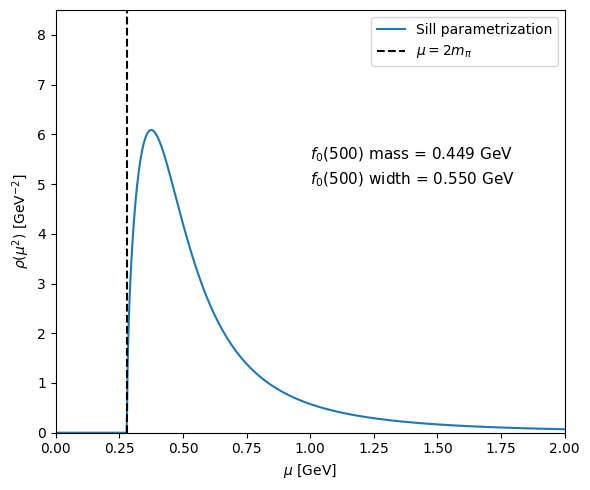

In [7]:
mu = np.linspace(0.0, 2.0, 1000)
rho = spectral_function(mu)

plt.figure(figsize=(6, 5))
plt.plot(mu, rho, label="Sill parametrization")
plt.axvline(2 * m_pi, linestyle="--", color="k", label=r"$\mu = 2m_\pi$")
plt.text(1, 5.5, rf"$f_0(500)$ mass = {f0_mass:.3f} GeV", fontsize=11)
plt.text(1, 5.0, rf"$f_0(500)$ width = {f0_width:.3f} GeV", fontsize=11)

plt.ylim(0, 8.5)
plt.xlim(0, 2.0)

plt.xlabel(r"$\mu$ [GeV]")
plt.ylabel(r"$\rho(\mu^2)$ [GeV$^{-2}$]")
plt.legend()
plt.tight_layout()
plt.savefig("Plots/f0_stuff/f0_spectral_function.png", dpi=300)

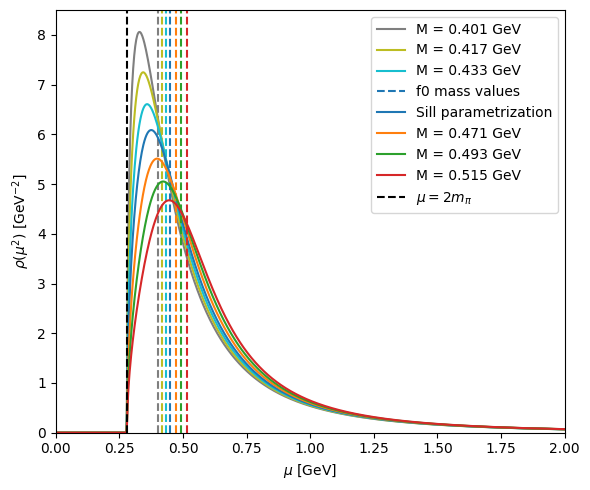

In [8]:
mu = np.linspace(0.0, 2.0, 1000)
f0_masses = [f0_mass - 3*f0_mass_err_minus, f0_mass - 2*f0_mass_err_minus, f0_mass - f0_mass_err_minus, f0_mass, f0_mass + f0_mass_err_plus, f0_mass + 2*f0_mass_err_plus, f0_mass + 3*f0_mass_err_plus]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(6, 5))

for i, mass in enumerate(f0_masses):
    rho = spectral_function(mu, M=mass)
    plt.axvline(mass, linestyle="--", color=colors[i-3], label=r"f0 mass values" if i==3 else None)
    plt.plot(mu, rho, color=colors[i-3], label="Sill parametrization" if i==3 else f"M = {mass:.3f} GeV")
plt.axvline(2 * m_pi, linestyle="--", color="k", label=r"$\mu = 2m_\pi$")

plt.ylim(0, 8.5)
plt.xlim(0, 2.0)

plt.xlabel(r"$\mu$ [GeV]")
plt.ylabel(r"$\rho(\mu^2)$ [GeV$^{-2}$]")
plt.legend()
plt.tight_layout()
plt.savefig("Plots/f0_stuff/f0_spectral_function_mass_variation.png", dpi=300)

In [9]:
mu2 = np.linspace(2*m_pi, 2.0, 5000)
rho = spectral_function(mu2)

# normalize
norm = np.trapezoid(rho, mu2)
rho_norm = rho / norm

print(f"Normalization factor: {norm:.4f}")

cdf = np.cumsum(rho_norm) * (mu2[1] - mu2[0])

Normalization factor: 2.1843


In [19]:
def quantile_func(mu2, cdf, q):
    return np.interp(q, cdf, mu2)

percentiles = np.arange(0.05, 1.0, 0.05)
quantiles = [quantile_func(mu2, cdf, q) for q in percentiles]

print("Quantiles:")
for q, val in zip(percentiles, quantiles):
    print(f"{q:.1%}: {val:.3f} GeV")

Quantiles:
5.0%: 0.314 GeV
10.0%: 0.335 GeV
15.0%: 0.354 GeV
20.0%: 0.372 GeV
25.0%: 0.390 GeV
30.0%: 0.408 GeV
35.0%: 0.427 GeV
40.0%: 0.448 GeV
45.0%: 0.470 GeV
50.0%: 0.494 GeV
55.0%: 0.520 GeV
60.0%: 0.551 GeV
65.0%: 0.587 GeV
70.0%: 0.630 GeV
75.0%: 0.683 GeV
80.0%: 0.751 GeV
85.0%: 0.846 GeV
90.0%: 0.991 GeV
95.0%: 1.252 GeV


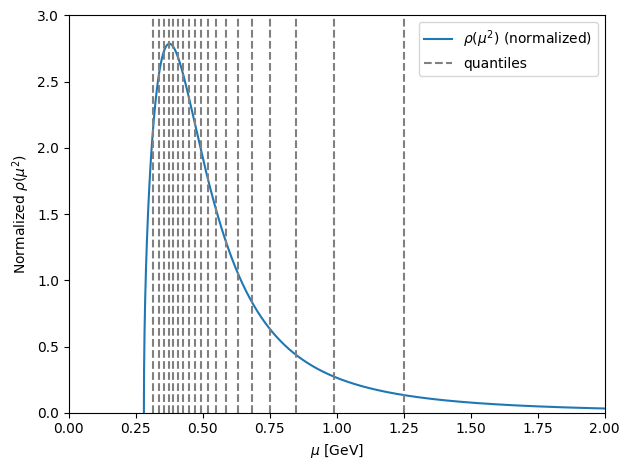

In [11]:
plt.plot(mu2, rho_norm, label=r"$\rho(\mu^2)$ (normalized)")

for q, val in zip(percentiles, quantiles):
    plt.axvline(val, linestyle="--", color="gray", label=f"quantiles" if q == 0.5 else None)

plt.ylim(0, 3.0)
plt.xlim(0, 2.0)

plt.xlabel(r"$\mu$ [GeV]")
plt.ylabel(r"Normalized $\rho(\mu^2)$")
plt.legend()
plt.tight_layout()
plt.savefig("Plots/f0_stuff/f0_spectral_function_quantiles.png", dpi=300)


In [21]:
def get_quantiles(mass: float):
    mu = np.linspace(2*m_pi, 2.0, 5000)
    rho = spectral_function(mu, M=mass)
    # normalize
    norm = np.trapezoid(rho, mu)
    rho_norm = rho / norm
    cdf = np.cumsum(rho_norm) * (mu[1] - mu[0])
    percentiles = np.arange(0.05, 1.0, 0.05)
    quantiles = [quantile_func(mu, cdf, q) for q in percentiles]
    return quantiles

for i, quantile in enumerate(get_quantiles(f0_mass)):
    print(f"Quantile { (i+1)*5 }%: {quantile:.3f} GeV")
    particle_df.loc[particle_df["ID"] == id, "Mass (GeV)"] = quantile
    output_path = f"Datafiles_sampled/f0_width_study/v1/PDG2016Plus_{i+8}.dat"
    parser.parse_to_dat(output_path, particle_df, decay_df)
    reverser.reverse_single_file(output_path)

Quantile 5%: 0.314 GeV
Data successfully written to Datafiles_sampled/f0_width_study/v1/PDG2016Plus_8.dat
Reversed file created: Datafiles_sampled/f0_width_study/v1/PDG2016Plus_8_reversed.dat
Quantile 10%: 0.335 GeV
Data successfully written to Datafiles_sampled/f0_width_study/v1/PDG2016Plus_9.dat
Reversed file created: Datafiles_sampled/f0_width_study/v1/PDG2016Plus_9_reversed.dat
Quantile 15%: 0.354 GeV
Data successfully written to Datafiles_sampled/f0_width_study/v1/PDG2016Plus_10.dat
Reversed file created: Datafiles_sampled/f0_width_study/v1/PDG2016Plus_10_reversed.dat
Quantile 20%: 0.372 GeV
Data successfully written to Datafiles_sampled/f0_width_study/v1/PDG2016Plus_11.dat
Reversed file created: Datafiles_sampled/f0_width_study/v1/PDG2016Plus_11_reversed.dat
Quantile 25%: 0.390 GeV
Data successfully written to Datafiles_sampled/f0_width_study/v1/PDG2016Plus_12.dat
Reversed file created: Datafiles_sampled/f0_width_study/v1/PDG2016Plus_12_reversed.dat
Quantile 30%: 0.408 GeV
Data s

In [29]:
def f0_width_study():
    f0_mass = 0.449
    f0_mass_err_plus = 0.022
    f0_mass_err_minus = 0.016
    f0_masses = [f0_mass, f0_mass + 1*f0_mass_err_minus, f0_mass - 1*f0_mass_err_minus, f0_mass + 2*f0_mass_err_minus, f0_mass -2*f0_mass_err_plus, f0_mass + 3*f0_mass_err_plus, f0_mass - 3*f0_mass_err_plus]

    for j, mass in enumerate(f0_masses):
        quantiles = get_quantiles(mass)
        for i, quantile in enumerate(quantiles):
            print(f"Mass variation {mass}, Quantile { (i+1)*5 }%: {quantile:.3f} GeV")
            particle_df.loc[particle_df["ID"] == id, "Mass (GeV)"] = quantile
            index = i + 8 + (j)*len(quantiles)
            print(f"Generating file with index {index}")
            output_path = f"Datafiles_sampled/f0_width_study/v1/PDG2016Plus_{index}.dat"
            parser.parse_to_dat(output_path, particle_df, decay_df)
            reverser.reverse_single_file(output_path)

f0_width_study()

Mass variation 0.449, Quantile 5%: 0.314 GeV
Generating file with index 8
Data successfully written to Datafiles_sampled/f0_width_study/v1/PDG2016Plus_8.dat
Reversed file created: Datafiles_sampled/f0_width_study/v1/PDG2016Plus_8_reversed.dat
Mass variation 0.449, Quantile 10%: 0.335 GeV
Generating file with index 9
Data successfully written to Datafiles_sampled/f0_width_study/v1/PDG2016Plus_9.dat
Reversed file created: Datafiles_sampled/f0_width_study/v1/PDG2016Plus_9_reversed.dat
Mass variation 0.449, Quantile 15%: 0.354 GeV
Generating file with index 10
Data successfully written to Datafiles_sampled/f0_width_study/v1/PDG2016Plus_10.dat
Reversed file created: Datafiles_sampled/f0_width_study/v1/PDG2016Plus_10_reversed.dat
Mass variation 0.449, Quantile 20%: 0.372 GeV
Generating file with index 11
Data successfully written to Datafiles_sampled/f0_width_study/v1/PDG2016Plus_11.dat
Reversed file created: Datafiles_sampled/f0_width_study/v1/PDG2016Plus_11_reversed.dat
Mass variation 0.44

In [7]:
output_path = "Datafiles_sampled/f0_width_study/v1/PDG2016Plus_8.dat"
parser.parse_to_dat(output_path, particle_df, decay_df)
reverser.reverse_single_file(output_path)

Data successfully written to Datafiles_sampled/f0_width_study/v1/PDG2016Plus_8.dat
Reversed file created: Datafiles_sampled/f0_width_study/v1/PDG2016Plus_8_reversed.dat


## Edge study

In [3]:
with open("logs/edge.txt", "w") as f:
    with redirect_stdout(f):
        edge_study(particle_df, decay_df, cut=0, verbose=True)
        #edge_study(particle_df, decay_df, cut=1e-4)
        #edge_study(particle_df, decay_df, cut=1e-5)
        

## Sampling study

In [ ]:
# dir_name = "Datafiles_sampled/sampling_studys/both_3sigma"

# with open("logs/sampling.txt", "w") as f:
#     with redirect_stdout(f):
#         sampling_study(particle_df, decay_df, dir_name, case="both", cut=0, f0_bool=False, verbose=True)
#         #sampling_study(particle_df, decay_df, dir_name, case="br", cut=1e-4, f0_bool=False, verbose=True)
#         #sampling_study(particle_df, decay_df, dir_name, case="mass", cut=1e-5, verbose=False)